# ESSC4510/EASC5510

## Filter and convolution

The following tutorial demonstate

- Modeling linear time invariant system
- Inverting empirical green's function
- Convolution and filtering

Date: 03/2021 
@Jw

In [1]:
# eda07_00 clear all variables and import vatious modules
%reset -f
import os
from datetime import date
from math import exp, pi, sin, sqrt, floor, ceil
import numpy as np
import scipy.sparse.linalg as las
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;


def GLSFilterMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where G is a topplitz matrix built from the filter g
    # Note that "H" must be sparese and called "edaHsparse" and that
    # the filter "g" bust be called edafilterg and must be a column vector
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    # implements (GT G + HT H) v
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel()); # G v is of length N
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = edaHsparse * v; # H v is of length K
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve((np.flipud(edafilterg)).ravel(),a.ravel()); # GT (G v) is of length M
    a2 = temp2[N-1:N+M-1,0];
    b2 = edaHsparse.transpose()*b; # HT (H v) is of length M
    # FT F v = GT G v + HT H v
    return (a2+b2);

### 0.1 Summary of Filters

**Definition of a filter**
   
A filter is a time series **f** (of length L) that expresses a linear relationship between an output time series **d** (of length N) and an input time series **m** (of length M = N) through an operation called a *convolution*.


**Convolution notation**
$$d = f \circledast m \text{   which is equivalent to   } d = m \circledast f $$
$\circledast$ denotes convolution operations.


**When to use a filter**

Use a filter when **d** depends on the past history of **m**.

**Length of a filter**

L expresses the duration of the past that influences the present. Filters can be of any length, but short filters (L << N) usually behave better than long filters.


**Matrix forms of the convolution**

Refer to Crib Sheet 7.1

**Computing a convolution**


    d = np.convolve(f,m) # perform convolution
    d = d[0:N] # truncate result to length N (optional)

### 1.1 Heat-production layer - Example filter problem

#### 1.1.1 Parameterize  Problem

Consider a heat-production layer with the following properties

In [2]:
# Example of a filter problem
# using impulse response of a heat-production layer

# time setup for g (length M)
M = 1024
N=M
Dtdays = 0.5
tdays = np.zeros((N,1))
tdays[:,0] = Dtdays*np.linspace(0,(N-1),N)
Dtseconds = Dtdays*3600*24
tseconds = Dtseconds*tdays

In [3]:
# material constants
rho = 1500      # kg/m3
cp = 800        # J/kg K
kappa = 1.25e-6 # m2/s
z = 1           # m

#### 1.1.2 Filter as the impulse response of the system

Impulse response: Consider a spike $\delta(x_0,t_0)$ at $x = x_0, t = t_0$ in the system. The response of the system is the impulse response.

- Here is the analytical solution from the heat diffusion equation (please refer to ESSC3120)

- Derivation please refer: https://esscstudycenter.github.io/materials/Handbook.pdf pp.151-153

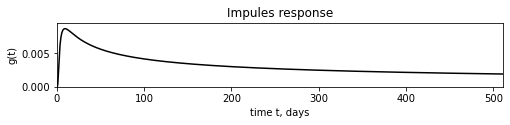

In [4]:
# impulse response
g = np.zeros((M,1))
g[0,0] = 0.0
P1 = (1/(rho*cp))
P2 = (Dtseconds/sqrt(2*pi))
P3 = np.reciprocal( np.sqrt(2*kappa*tseconds[1:M]))
P4 = np.exp( -0.5*(z**2)*np.reciprocal(2*kappa*tseconds[1:M]))
g[1:M,0] = (P1 * P2 * np.multiply(P3 ,P4)).ravel()

# plot impulse response
fig1 = plt.figure(1,figsize=(8,4));
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[M-1,0], 0, 1.1*np.max(g)] );
plt.plot(tdays[0:M],g,'k-');
plt.xlabel('time t, days');
plt.ylabel('g(t)');
plt.title('Impules response');

#### 1.1.3 Modeling real scenario

##### 1.1.3.1 True heat production
Consider two spike of heat source at t1 and t2, i.e. in the graph

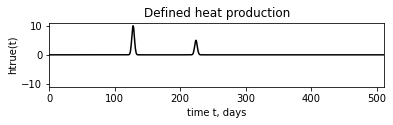

In [5]:
#true heat production
t1 = Dtdays*N/4;
t2 = Dtdays*7*N/16;
sd = Dtdays*N/256;
Ah=10;
P5 = np.exp(-np.power(tdays-t1,2) / (2*sd**2) );
P6 = np.exp(-np.power(tdays-t2,2) / (2*sd**2) );
htrue = np.zeros((N,1));          
htrue[:,0] = (Ah*P5 + 0.5*Ah*P6).ravel();

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:M],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Defined heat production');

##### 1.1.3.2 Analytical observations using convolution

$$\theta = H \circledast G $$

<img src="Figures/temperature_convolution.png">

Why can we use the convolution to compute the observation?

- 
- 

--> 

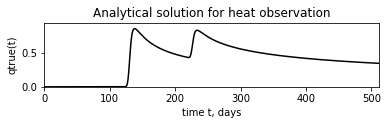

In [6]:
# preduct true temperature
qtrue = np.zeros((N,1))
tmp = np.convolve(g.ravel(), htrue.ravel())
qtrue[0:N,0]=tmp[0:N]

# plot true temperature
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qtrue)] );
plt.plot(tdays[0:N],qtrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('qtrue(t)');
plt.title('Analytical solution for heat observation');

#### 1.1.4 Inverse the heat production from observations

##### 1.1.4.1 Shape of G

Apart from the convolution, we can also analysis using linear model. 

What is the shape of G for the convolution with the impulse reponse?


<img src="Figures/temperature_time_invariant.png
">

Can you find casuality in the kernal G?

Can you plot the an impulse response from G?

In [7]:
# create simulated observations, qobs = qtrue+noise
sigmad=0.001*np.amax(qtrue);
qobs=qtrue +np.random.normal(0,sigmad,(N,1));



# matrix version of impulse response
Gcol = np.concatenate((g,np.zeros((N-M,1))),axis=0);
v = np.zeros((1,1));
v[0,0]=g[0,0];
Grow = np.concatenate((v,np.zeros((1,M-1))),axis=1);
G = la.toeplitz( Gcol, Grow )

# EDA DRAW G

            

qtrue2 = np.matmul(G,htrue);


#### 1.1.4.2 Singularity of inv(GTG)

Is this a valid solvable problem? (Using least square method)

When does least square method fails?

##### 1.1.4.3 Solving using gernealized least square method (1)

Too address the ill-condition problem, we will incoperate **prior information** in our analyis

In the lecture, we briefly introduced the generalized least square methods. Details could be found in chapter 5 *Quantifying preconceptions*.

1) Damped least square solution

Prior information: $m^{est}$ is small as $\sigma_h$

$$(G^TG)' = \epsilon^2I +G^TG \text{ ,   with }\epsilon = σ_d/σ_h$$

$$ m^{est} = [G^TG]'^{-1}G^T d^{obs}$$

ε=0: minimize the prediction error

ε→∞: minimize the size of the model parameters 

0<ε<∞: minimize a combination of the two


**Change** $\epsilon$ 

---

Advantages:
- really easy to code - always works

Disadvantages:
- often need to determine ε empirically
- prior information that the model parameters are small not always sensible

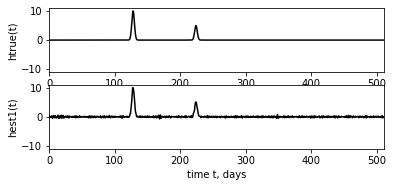

In [8]:
# solve for h given qobs and g using least squares
GTG = np.matmul(G.T,G);
GTGmax = np.amax(GTG);
e2=1e-4*GTGmax;
hest1 = la.solve(GTG+e2*np.identity(M), np.matmul(G.T,qobs) );

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest1,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest1(t)');
plt.show();

##### 1.1.4.3 Solving using gernealized least square method (2)
Prior information: Smoothness


<img src="Figures/smoothness_prior.png
">
Solving generalized least square equation - **Fm=f**

In [9]:
# for comparison purposes, solve for h given qobs and g using least squares
GTG = np.matmul(G.T,G);
GTGmax = np.amax(GTG);
e2=1e-2*GTGmax;
hest2 = la.solve(GTG+e2*np.identity(M), np.matmul(G.T,qobs) );

# generalized leasr squares with F = [G; H]  and  f = [qobs, 0]
# second derivative smoothing in interior of interval; nothing on ends
e=10*np.amax(G);
Hcol = np.zeros((M-2,1));
Hcol[0,0] = e;
Hrow = np.zeros((1,M));
Hrow[0,0] = e;
Hrow[0,1] = -2*e;
Hrow[0,2] = e;
H = la.toeplitz( Hcol, Hrow );
h = np.zeros((M-2,1))
F = np.concatenate( (G,H), axis=0 );
f = np.concatenate( (qobs,h), axis=0 );
FTF = np.matmul(F.T,F);
hest3 = la.solve(FTF, np.matmul(F.T,f) );

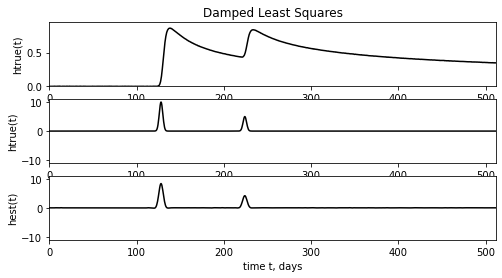

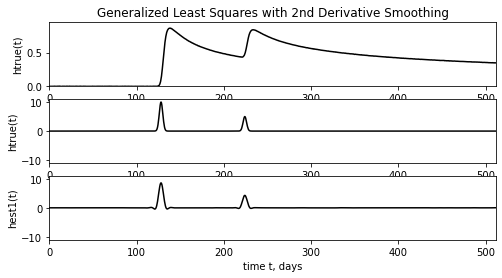

In [10]:
# figure 1
fig1 = plt.figure(1,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Damped Least Squares');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest2,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest(t)');
plt.show();

# figure 2
fig2 = plt.figure(2,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');
plt.title('Generalized Least Squares with 2nd Derivative Smoothing');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest3,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest1(t)');
plt.show();

## 2.1 Prediction

$$\text{present value = linear function of past values}$$

* have to define the length of the linear function

$$d_i = p_2d_{i-1} + p_3d_{i-2} + p_4d_{i-3} + ...+ p_Md_{i-M-1}$$

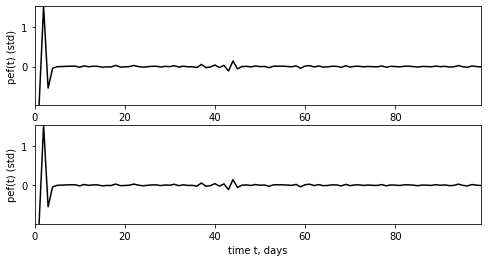

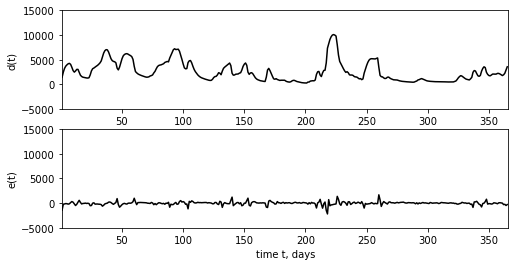

In [11]:
# eda07_05
# prediction error filter (pef) for Neuse Rievr Hydrograph
# this code uses generalized least squares to implement
# the prior information that pef(1)=(-1).  Two solutions
# are calculated, one via standard matrix algebra,
# (FTF)\(FTf) and the other via the biconjugate gradient method


# read in data
D = np.genfromtxt('data/neuse.txt', delimiter='\t')
[N, K]=D.shape;
t = np.zeros((N,1)); 
t[:,0] = D[:,0]; # time in days
d = np.zeros((N,1));
d[:,0] = D[:,1]; # discharge in cubic meters per second
Dt = t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];

# sizes of various arrays
M=100; # length of pef is user tunable
K=1;
L=N+K;

# for a prediction error filter, pef, the data is the filter, g
g = d;
edafilterg = d;

# prior information that first element of the pef is (-1)
e=(10^1)*np.amax(g); # large weight
H=np.zeros((K,M));
H[0,0]=e;
h=np.zeros((1,1));
h[0,0]=(-e);

# Data Kernel (needed only for standard matrix algebra calculation
v = np.zeros((1,1));
v[0,0]=g[0,0];
Grow = np.concatenate((v,np.zeros((1,M-1))),axis=1);
G = la.toeplitz( g, Grow );
# for pef, Gm=0

# F needed only for standard matrix algebra calculation
F = np.concatenate( (G, H), axis=0 );
rhs = np.zeros((N,1));
f = np.concatenate( (rhs, h), axis=0 );

# standard GLS solution
FTF = np.matmul( F.T, F );
FTf = np.matmul( F.T, f );
pef1 = la.solve(FTF, FTf );        

# now set up for biconjugate gradient method

# Hm=h
e=(10^1)*np.amax(g); # large weight
edaHsparse = sparse.diags([e], [0], shape=(1, M));
h=np.zeros((1,1));
h[0,0]=(-e);

# FT f can be done analytucally:
# FTf = GT 0 + HT h = 0 + [e 0 0 ... 0]T [-e] = [-e^2 0 0 ... 0]T
FTf = np.zeros((M,1));
FTf[0,0] = -(e**2);
           
# define linear operator needed for conjugate gradienet solver
LO=las.LinearOperator(shape=(M,M),matvec=GLSFilterMul,rmatvec=GLSFilterMul);

# solve for estimated model parameters using congugate gradient algrorithm
r = np.zeros((M,1));
q=las.cg(LO,FTf,tol=1e-6, maxiter=(3*(N+M)+100));
pef2 = np.zeros((M,1));
pef2[:,0] = q[0];

# prediction error
temp = np.convolve(pef2.ravel(),g.ravel());
perror = np.zeros((N,1));
perror[:,0] = temp[0:N]
           
# short time axis
tpef = np.zeros((M,1));    
tpef[:,0] = t[0:M,0];
           
# plot pef
fig1 = plt.figure(1,figsize=(8,4));

# plot prediction error filters
ax1 = plt.subplot(2,1,1);
plt.axis([ 0, Dt*(M-1), np.min(pef1), np.max(pef1)] );
plt.plot(tpef,pef1,'k-');
plt.xlabel('time t, days');
plt.ylabel('pef(t) (std)');

ax1 = plt.subplot(2,1,2);
plt.axis([ 0, Dt*(M-1), np.min(pef1), np.max(pef1)] );
plt.plot(tpef,pef2,'k-');
plt.xlabel('time t, days');
plt.ylabel('pef(t) (std)');
plt.show();

# plot hydrograph data and prediction error for first year
fig2 = plt.figure(2,figsize=(8,4));

Np = 365;
ax1 = plt.subplot(2,1,1);
plt.axis([tmin, tmin+Dt*Np, -5000, 15000]);
plt.plot(t[0:Np,0],d[0:Np,0],'k-');
plt.xlabel('time t, days');
plt.ylabel('d(t)');

ax1 = plt.subplot(2,1,2);
plt.axis([tmin, tmin+Dt*Np, -5000, 15000]);
plt.plot(t[0:Np,0],perror[0:Np,0],'k-');
plt.xlabel('time t, days');
plt.ylabel('e(t)');
plt.show();        

### 0.0 Mathematical definition of linear, time invariant, causal system (Causal Filter) [Optional]
Definition 1: A system mapping $x$ to $y$ is causal if and only if, for any pair of input signals $ x_{1}(t)$, $x_{2}(t)$ and any choice of $t_{0}$, such that

$$x_{1}(t)=x_{2}(t),\quad \forall \ t<t_{0}$$
the corresponding outputs satisfy

$$y_{1}(t)=y_{2}(t),\quad \forall \ t<t_{0}.$$

Definition 2: Suppose $h(t)$ is the impulse response of any system $H$ described by a linear constant coefficient differential equation. The system $H$ is causal if and only if

$$h(t)=0,\quad \forall \ t<0$$
otherwise it is non-causal.